In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

In [2]:
column_names = ['Names', 'MCG','GVH' ,'LIP','CHG','AAC','ALM1','ALM2','SITE']
ecoli_df = pd.read_csv('./uci_repos/ecoli/ecoli.data',
                      sep="   |  ",
                                   names=column_names, 
                                   header=None, 
                                   engine="python")
ecoli_df

,Names,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,SITE
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...,...
331,TREA_ECOLI,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
332,UGPB_ECOLI,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
333,USHA_ECOLI,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
334,XYLF_ECOLI,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [3]:
ecoli_df.describe()

,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


In [4]:
del ecoli_df['Names']
class_names = ecoli_df['SITE'].unique()
class_names

array(['cp', 'im', 'imS', 'imL', 'imU', 'om', 'omL', 'pp'], dtype=object)

In [5]:
ecoli_df.head()

,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,SITE
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


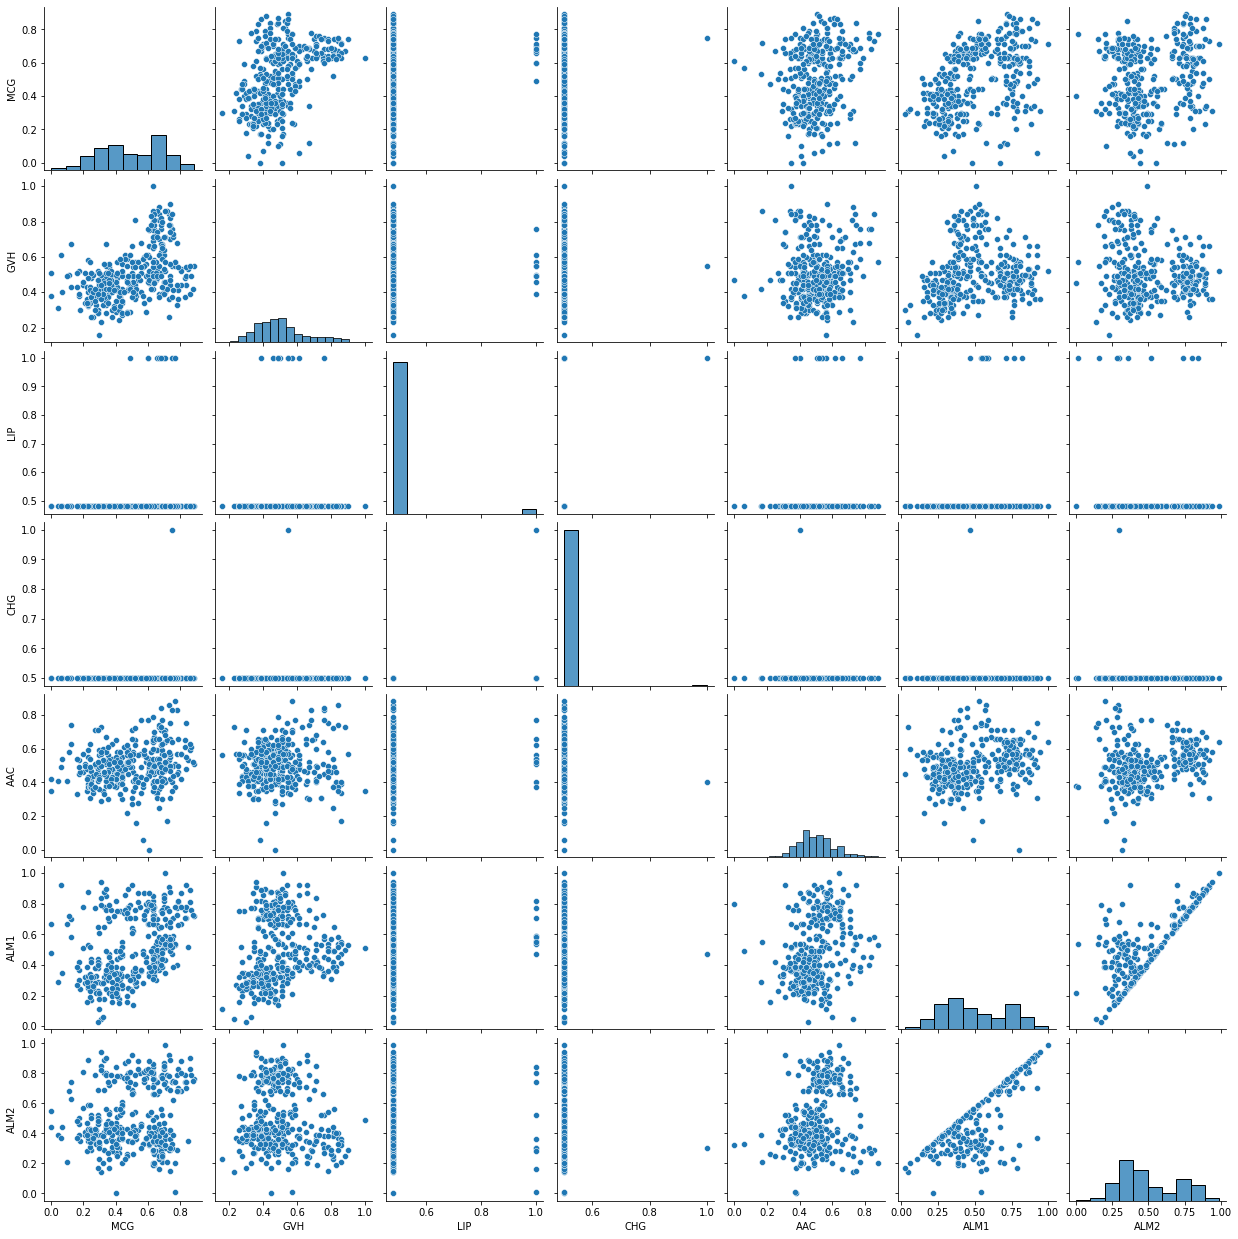

In [6]:
sns.pairplot(ecoli_df)

In [7]:
Y = ecoli_df.iloc[:,-1:].copy().to_numpy() 
X = ecoli_df.iloc[:, 0:-1].copy().to_numpy()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [9]:
from sklearn.preprocessing import LabelEncoder
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [10]:
print(np.unique(y_train))
print(np.unique(y_test))
print(X_train.shape)

[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6]
(268, 7)


In [11]:
y_train_oh = np.array(tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='float32'))
X_train = np.array(X_train)

# VAE Model

In [12]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 16
z_dim = 3
X_dim = 7
y_dim = 8
h_dim = 3
lr = 1e-3


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

X_samples, _ = P(z, c)

recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

i = 0

for it in range(50000):
    ind = np.random.choice(X_train.shape[0], mb_size)
    X_mb = np.array(X_train[ind])
    y_mb = np.array(y_train_oh[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()
    

Instructions for updating:
non-resource variables are not supported in the long term


2021-09-27 10:09:21.543252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 10:09:21.548970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-09-27 10:09:21.549735: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-09-27 10:09:21.550188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0
Loss: 5.509

Iter: 1000
Loss: 4.777

Iter: 2000
Loss: 4.76

Iter: 3000
Loss: 4.668

Iter: 4000
Loss: 4.647

Iter: 5000
Loss: 4.643

Iter: 6000
Loss: 4.69

Iter: 7000
Loss: 4.678

Iter: 8000
Loss: 4.652

Iter: 9000
Loss: 4.693

Iter: 10000
Loss: 4.636

Iter: 11000
Loss: 4.756

Iter: 12000
Loss: 4.665

Iter: 13000
Loss: 4.686

Iter: 14000
Loss: 4.784

Iter: 15000
Loss: 4.673

Iter: 16000
Loss: 4.646

Iter: 17000
Loss: 4.665

Iter: 18000
Loss: 4.573

Iter: 19000
Loss: 4.674

Iter: 20000
Loss: 4.664

Iter: 21000
Loss: 4.693

Iter: 22000
Loss: 4.655

Iter: 23000
Loss: 4.721

Iter: 24000
Loss: 4.65

Iter: 25000
Loss: 4.665

Iter: 26000
Loss: 4.628

Iter: 27000
Loss: 4.608

Iter: 28000
Loss: 4.606

Iter: 29000
Loss: 4.684

Iter: 30000
Loss: 4.822

Iter: 31000
Loss: 4.603

Iter: 32000
Loss: 4.659

Iter: 33000
Loss: 4.521

Iter: 34000
Loss: 4.683

Iter: 35000
Loss: 4.598

Iter: 36000
Loss: 4.633

Iter: 37000
Loss: 4.737

Iter: 38000
Loss: 4.618

Iter: 39000
Loss: 4.684

Iter: 40000
Loss

In [13]:
### generating sample outputs after training
samples = []
gen_labels =[]
for r in range(10):
    for index in range(y_dim):
        gen_labels = gen_labels + [index]*mb_size
        y = np.zeros([mb_size, y_dim])
        y[range(mb_size), index] = 1
        samples.extend(sess.run(X_samples,
                               feed_dict={z: np.random.randn(mb_size, z_dim), c: y}))

gen_samples = np.array(samples).round(decimals=2)
gen_labels = np.array(gen_labels)
print(gen_samples.shape)
print(gen_labels.shape)

(1280, 7)
(1280,)


In [14]:
print(gen_labels)
print(gen_samples[0])

[0 0 0 ... 7 7 7]
[0.36 0.42 0.48 0.5  0.44 0.32 0.4 ]


In [15]:
gen_df = pd.DataFrame(data=gen_samples, columns=column_names[1:8])

In [16]:
gen_df['SITE'] = gen_labels
gen_df

,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,SITE
0,0.36,0.42,0.48,0.5,0.44,0.32,0.40,0
1,0.37,0.42,0.48,0.5,0.44,0.32,0.40,0
2,0.36,0.42,0.48,0.5,0.44,0.32,0.40,0
3,0.36,0.42,0.48,0.5,0.44,0.32,0.40,0
4,0.37,0.42,0.48,0.5,0.44,0.32,0.40,0
...,...,...,...,...,...,...,...,...
1275,0.67,0.68,0.49,0.5,0.51,0.47,0.37,7
1276,0.67,0.68,0.49,0.5,0.51,0.47,0.37,7
1277,0.67,0.68,0.49,0.5,0.51,0.47,0.37,7
1278,0.67,0.68,0.49,0.5,0.51,0.47,0.37,7


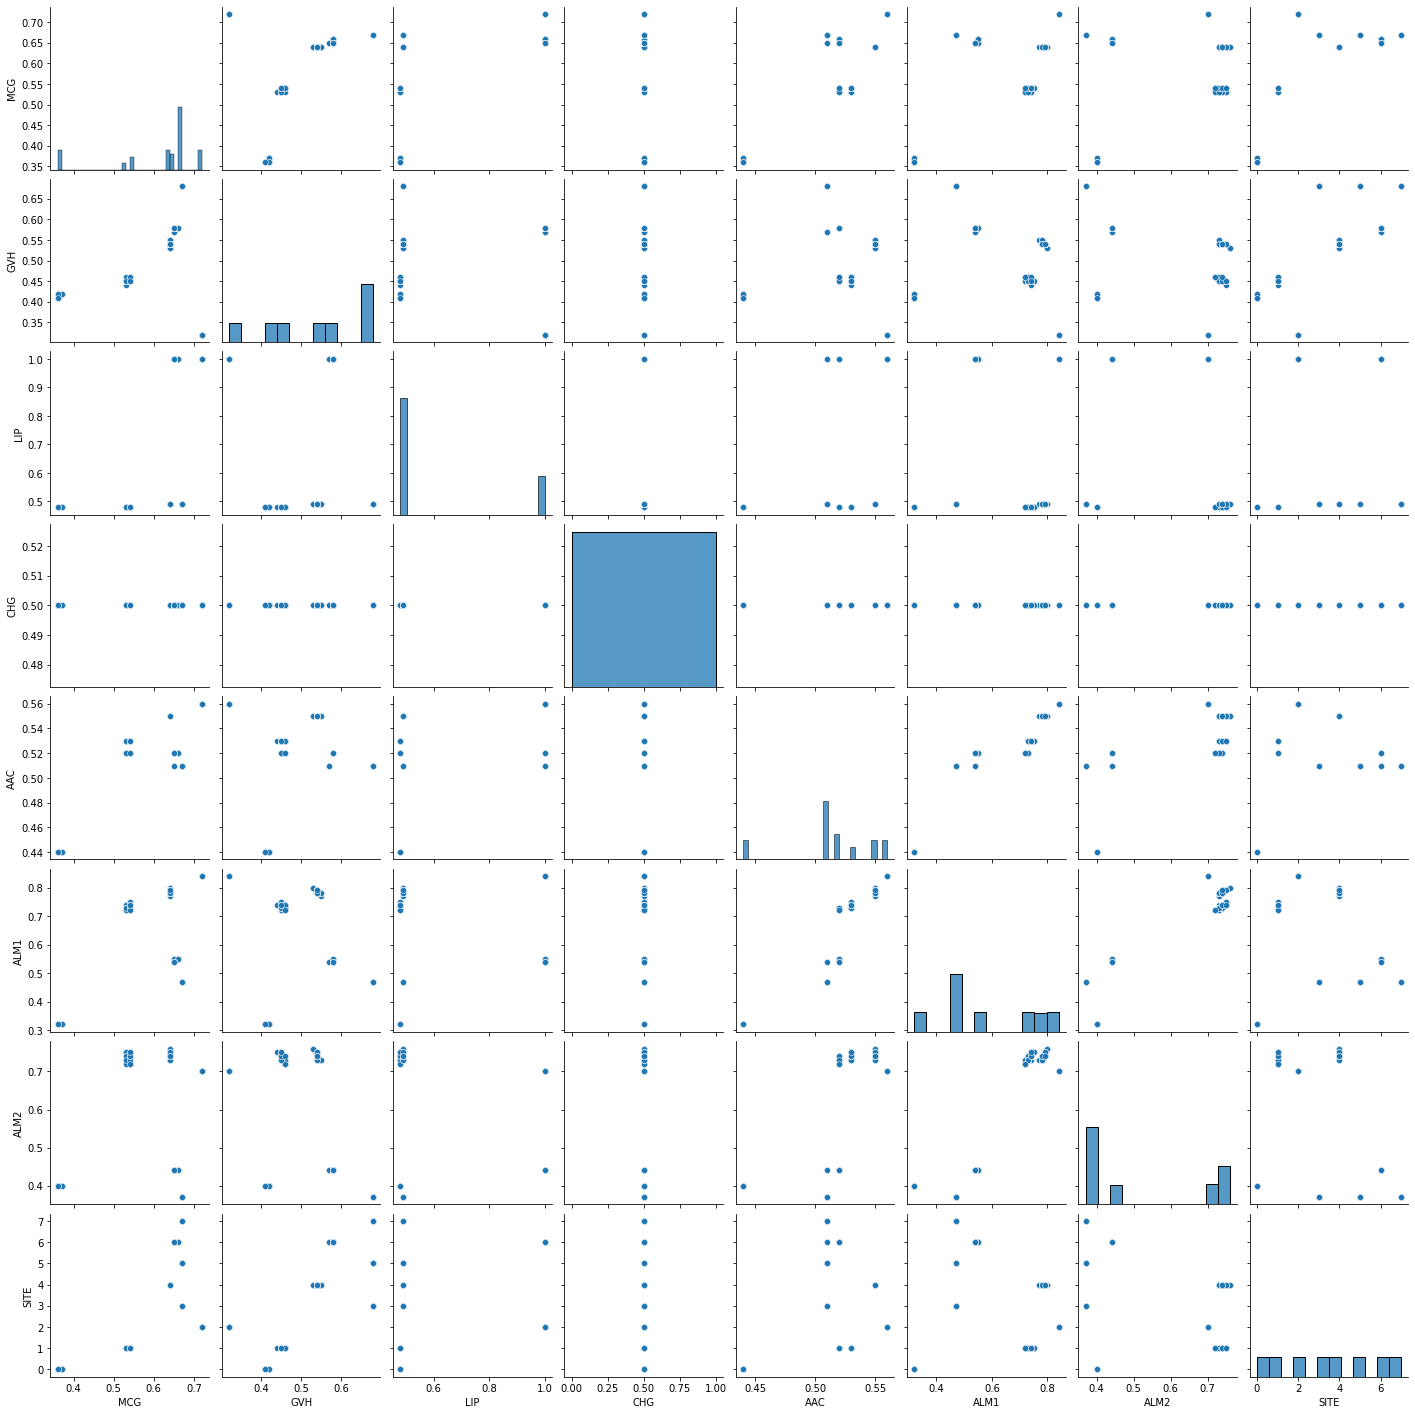

In [17]:
sns.pairplot(gen_df)

# 1. RF baseline

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6323529411764706

In [19]:
base_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, base_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       0.68      1.00      0.81        15
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         0

    accuracy                           0.63        68
   macro avg       0.19      0.25      0.22        68
weighted avg       0.50      0.63      0.56        68



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

# 2. Generated data only

In [20]:
rf_gen = RandomForestClassifier(max_depth=2, random_state=0)
x_train_gen, x_test_gen, y_train_gen, y_test_gen = train_test_split(gen_samples, gen_labels, 
                                                                    test_size=0.2, random_state=40)
rf_gen.fit(x_train_gen, y_train_gen)
gen_pred = rf_gen.predict(x_test_gen)
from sklearn.metrics import classification_report
print(classification_report(y_test_gen, gen_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        24
           3       0.28      1.00      0.44        30
           4       1.00      1.00      1.00        27
           5       0.00      0.00      0.00        42
           6       1.00      1.00      1.00        29
           7       0.00      0.00      0.00        34

    accuracy                           0.70       256
   macro avg       0.66      0.75      0.68       256
weighted avg       0.62      0.70      0.64       256



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

# 3. Train on real test on generated 

In [21]:
gen_pred3 = rf.predict(x_test_gen)
from sklearn.metrics import classification_report
print(classification_report(y_test_gen, gen_pred3))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        37
           1       0.39      1.00      0.56        33
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        27
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        29
           7       0.32      1.00      0.49        34

    accuracy                           0.41       256
   macro avg       0.16      0.38      0.22       256
weighted avg       0.17      0.41      0.24       256



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

# 4. Train on generated and test on real 

In [22]:
gen_pred4 = rf_gen.predict(X_test)
print(classification_report(y_test, gen_pred4))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75        28
           1       1.00      0.20      0.33        15
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         7
           4       0.18      0.50      0.26         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10

    accuracy                           0.43        68
   macro avg       0.27      0.22      0.19        68
weighted avg       0.52      0.43      0.41        68



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

# 5. Train on real and generated

In [23]:
x = np.concatenate([X_train, x_train_gen])
y = np.concatenate([y_train, y_train_gen])

In [24]:
rf_combine = RandomForestClassifier(max_depth=2, random_state=0)
rf_combine.fit(x,y)
print('test accuracy on real data',rf_combine.score(X_test, y_test))

test accuracy on real data 0.6176470588235294


In [25]:
gen_pred5a= rf_combine.predict(X_test)
print(classification_report(y_test, gen_pred5a))

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        28
           1       0.67      0.93      0.78        15
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         0

    accuracy                           0.62        68
   macro avg       0.19      0.24      0.21        68
weighted avg       0.49      0.62      0.54        68



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
gen_pred5b= rf_combine.predict(x_test_gen)
print('### generated test samples  only')
print(classification_report(y_test_gen, gen_pred5b))

### generated test samples  only
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        24
           3       0.00      0.00      0.00        30
           4       1.00      1.00      1.00        27
           5       0.00      0.00      0.00        42
           6       1.00      1.00      1.00        29
           7       0.32      1.00      0.49        34

    accuracy                           0.72       256
   macro avg       0.67      0.75      0.69       256
weighted avg       0.63      0.72      0.65       256



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [27]:
combine_x = np.concatenate([X_test, x_test_gen])
combine_y = np.concatenate([y_test, y_test_gen])

In [28]:
gen_pred5c = rf_combine.predict(combine_x)
print('#### combine results ####')
print(classification_report(combine_y, gen_pred5c))

#### combine results ####
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        65
           1       0.87      0.98      0.92        48
           2       1.00      0.96      0.98        25
           3       0.00      0.00      0.00        37
           4       1.00      0.82      0.90        33
           5       0.00      0.00      0.00        43
           6       0.94      0.74      0.83        39
           7       0.29      1.00      0.45        34

    accuracy                           0.70       324
   macro avg       0.63      0.69      0.63       324
weighted avg       0.63      0.70      0.64       324



/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

# MLP experiment

In [29]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential


def build_model(input_shape=(64,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [38]:
baseline_model = build_model((7,), 8)
batch_size=8
epochs=2
test_y = np.array(tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='float32'))
history_baseline = baseline_model.fit(X_train, y_train_oh, batch_size=batch_size, 
                    epochs=epochs, validation_data=(X_test, test_y))
score_baseline = baseline_model.evaluate(X_test, test_y, verbose=0)
print('baseline test loss: ',score_baseline[0])
print('baseline test accuracy: ', score_baseline[1] )

y_pred_baseline_oh = baseline_model.predict(X_test)
y_pred_baseline = y_pred_baseline_oh.argmax(axis=-1)
print('MLP baseline classification report\n',classification_report(y_test, y_pred_baseline))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


268/268 [==============================] - 0s 2ms/sample - loss: 2.6873 - acc: 0.2239 - val_loss: 2.0322 - val_acc: 0.4706
Epoch 2/2
268/268 [==============================] - 0s 272us/sample - loss: 1.6168 - acc: 0.5037 - val_loss: 1.9603 - val_acc: 0.4559
baseline test loss:  1.9602850605459774
baseline test accuracy:  0.45588234
MLP baseline classification report
               precision    recall  f1-score   support

           0       0.94      0.61      0.74        28
           1       0.32      0.93      0.47        15
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         0

    accuracy                           0.46        68
   macro avg       0.16      0.19      0.15        68
weighted avg       0.46      0.46 

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

# Training on real and generated data

In [42]:
x = np.array(x)
y_oh = np.array(tf.keras.utils.to_categorical(y, num_classes=8, dtype='float32'))
test_y = np.array(tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='float32'))
aug_model = build_model((7,), 8)
history_aug = aug_model.fit(x, y_oh, batch_size=batch_size, epochs=epochs, 
                            validation_data=(X_test, test_y))
y_pred_aug_oh = aug_model.predict(X_test)
y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
print('Combined MLP classification report on real samples only.\n',classification_report(y_test, y_pred_aug))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                256       
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)               

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para